# クラスタリング

## KMeansの学習と予測

クラスタリングの学習結果を理解しやすくするため、サンプルデータの生成から始めます。<br>
make_blobsは、各軸正規分布に従った乱数を生成してくれるデータ生成関数です。

In [1]:
!git clone https://github.com/saiku122/AIJobcolle.git

Cloning into 'AIJobcolle'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 279 (delta 108), reused 155 (delta 46), pack-reused 0
Receiving objects: 100% (279/279), 11.70 MiB | 12.63 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [2]:
cd /content/AIJobcolle/MachineLearning/python

/content/AIJobcolle/MachineLearning/python


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
%matplotlib inline
import matplotlib.pyplot as plt

X, labels_true = make_blobs(
    n_samples=1000,               # サンプル数
    centers=[[-5,-5],[0,0],[5,5]],# クラスタ重心座標設定(3クラスタを2次元で作成)
    cluster_std=1.0,              # 乱数生成時の標準偏差
    random_state=0)
print('Generated data X:\n', X[:5])
print('Generated data y:\n', labels_true[:5])

Generated data X:
 [[-6.04855297 -6.42001794]
 [-3.23594765 -4.59984279]
 [ 4.50420451  6.21657771]
 [ 2.11679102 -1.6108784 ]
 [ 4.26912641  3.35829677]]
Generated data y:
 [0 0 2 1 2]


横軸をX0、縦軸をX1として、生成したサンプルデータを可視化します。<br>
クラスタリングによって期待されるのは、データがいずれのクラスタに属するかを正しく予測することです。

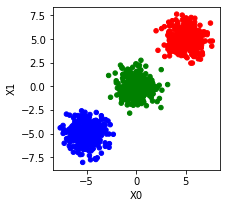

In [4]:
df = pd.DataFrame(np.hstack([X,labels_true.reshape(len(labels_true),1)]),
                  columns=["X0","X1","label"])
col = df.label.map({0:'b', 1:'g', 2:'r'})
df.plot(x='X0', y='X1', kind='scatter', c=col, colorbar=False, figsize=(3,3))

KMeansの実行です。KMeansではクラスタ数を設定する必要があるため3としました。<br>
下記では学習されたクラスタ重心座標を出力しています。<br>先ほど私達が設定した値とほぼ合致することを確認して下さい。

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
kmeans = KMeans(n_clusters=3, random_state=0)

scl = StandardScaler()
X_std = scl.fit_transform(X)
kmeans.fit(X_std)

print(kmeans.cluster_centers_[0], ':Centroid-0 is a cluster Green')
print(kmeans.cluster_centers_[1], ':Centroid-1 is a cluster Blue')
print(kmeans.cluster_centers_[2], ':Centroid-2 is a cluster Red')

[1.18185453 1.19622489] :Centroid-0 is a cluster Green
[-1.20075939 -1.18599884] :Centroid-1 is a cluster Blue
[ 0.02251074 -0.00666449] :Centroid-2 is a cluster Red


学習したモデルを使って未知座標Xのクラスタ番号の予測をしましょう。<br>予測ロジックは単純で予測したいデータと最も近いクラスタ重心座標を持つクラスタ番号を返しているだけです。

In [8]:
kmeans.predict([[-6,-4],[-2,0],[6,8]])
print(scl.transform([[-6,-4],[-2,0],[6,8]]))
kmeans.predict(scl.transform([[-6,-4],[-2,0],[6,8]]))

[[-1.41639207 -0.94130448]
 [-0.46790415  0.00352025]
 [ 1.42907169  1.8931697 ]]


array([1, 2, 0], dtype=int32)

### KMeansにおけるクラスタ数の決定

#### 問題意識
上記では3つの重心座標の周辺にデータを生成したため、私達はデータを3つのクラスタで学習させました。<br>しかし、実際のデータについてはこのような決定はできません。<br>それではクラスタ数をどのように決めたら良いでしょうか。

#### エルボー法
このような時に役立つのが<b>エルボー法</b>です。<br>
クラスタ数を変化させていったとき、クラスタ重心点とクラスタ所属点の間の距離の総和をプロットしたものです。<br>
クラスタ数が少ない場合、重心に近い点もあるでしょうが多くの点は遠方の点になるでしょう。<br>
またクラスタ数が十分に大きければその総和は0に近づくことが予想できます。<br><br>
<b>エルボー法はこの総和の低下が急速に進む箇所と緩やかに進む箇所、それらを分離する場所でクラスタ数の候補を得ましょう</b>というものです。<br>
さて、クラスタ重心点とクラスタ所属点の距離の総和はintertia_で取得できます。<br>
クラスタ数1以上11未満で、距離総和の減少の様子をプロットしてみましょう。

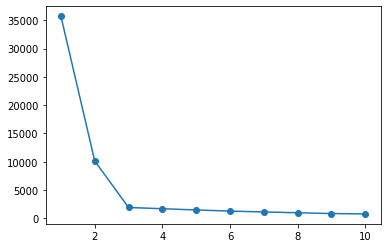

In [9]:
# エルボー図の作成
distortions = []
for i in range(1,11):
    km=KMeans(n_clusters=i, random_state=0).fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1,11), distortions, marker='o')

上記の通り、クラスタ数が3まではクラスタ数を増やすことで重心点とサンプル間の距離が急速に減少します。<br>
しかしクラスタを4以上にしても、もはやその低下幅は限定的です。<br>
以上より、このデータについてはクラスタ数は3で十分ではないかと考えるわけです。

## DBSCANによる学習と予測

最後に密度ベースのクラスタリングであるDBSCANの実装について学びます。<br>ここではDBSCANのご利益を確認すべくサンプルデータを変更します。<br>make_moons関数で、月型のデータサンプルを生成します。

In [ ]:
from sklearn.datasets import make_moons
X, labels_true = make_moons(
    n_samples=1000,
    noise=0.05,
    random_state=0)
print('Generated Data:\n', X[:5])
print('\nGenerated Label:\n', labels_true[:5])

以下で新しい生成サンプルデータの散布図を描いています。<br>色は本データの理想的なクラスタ分割のされ方です。

In [ ]:
df = pd.DataFrame(np.hstack([X, labels_true.reshape(len(labels_true),1)]),
                  columns=["X0","X1","label"])
col = df.label.map({0:'g', 1:'b'})
df.plot(x='X0', y='X1', kind='scatter', c=col, colorbar=False, figsize=(6,4))

さてこのデータをDBSCANで学習するとどうなるでしょうか。

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
fig2, ax2 = plt.subplots()

# 学習と予測を同時に実施
for j in range(3):
    ax2.plot(X[db.fit_predict(X) == j, 0],
             X[db.fit_predict(X) == j, 1], 'o',
             label='series ' + str(j))

上記の通り、このような形状にはDBSCANがフィットしていることがわかりました。実際のデータはより高次元でしょうからシンプルにKmeansが良い、DBSCANが良いと事前に決定することは困難です。クラスタ別に実施されたモデリングや施策効果結果などを通し、実証的にアルゴリズムを選択するなどしましょう。

<b>[確認してみよう]</b> 上記DBSCANのハイパーパラメータである`eps`を0.2から1.0に変更するとどうなるか確認してみよう。

<b>[確認してみよう]</b> ある調査への回答データが「mental_survey.tsv」に格納されています。脳の使い方には右脳型や左脳型があるなどと言われていますが、このデータからそのような傾向は確認できるでしょうか。データカラムの`Q1`から`Q20`の20変数をKMeans法でクラスタリングし、そのクラスタ重心の解釈をしてみて下さい。カラム内容は「mental_survey_codebook.txt」で確認できます。またサンプルデータは「タブ区切り」である点を留意ください。